In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline


# Import Data

In [2]:
email_table = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/email/email_table.csv')
email_table.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6
5,684440,long_email,personalized,6,Sunday,UK,3
6,139620,short_email,personalized,9,Saturday,US,8
7,694933,long_email,generic,8,Saturday,US,2
8,485760,long_email,personalized,5,Monday,US,4
9,592665,short_email,personalized,23,Wednesday,US,3


In [3]:
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
email_table.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
email_opened = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/email/email_opened_table.csv')
email_opened.head(10)

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034
5,935124
6,473874
7,158501
8,922766
9,378153


In [6]:
print(len(email_opened)==email_opened['email_id'].nunique())

True


In [7]:
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [9]:
link_table = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/email/link_clicked_table.csv')
link_table.head(10)

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561
5,790513
6,164034
7,284534
8,912656
9,829393


In [10]:
print(len(link_table) == link_table['email_id'].nunique())

True


In [11]:
link_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


# Data Processing

In [12]:
email_opened['opened'] = 1
link_table['clicked'] = 1

In [13]:
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_table, how='left', on ='email_id')
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN
5,684440,long_email,personalized,6,Sunday,UK,3,NaN,NaN
6,139620,short_email,personalized,9,Saturday,US,8,1.0,NaN
7,694933,long_email,generic,8,Saturday,US,2,NaN,NaN
8,485760,long_email,personalized,5,Monday,US,4,NaN,NaN
9,592665,short_email,personalized,23,Wednesday,US,3,NaN,NaN


In [14]:
data.isnull().sum()

email_id                   0
email_text                 0
email_version              0
hour                       0
weekday                    0
user_country               0
user_past_purchases        0
opened                 89655
clicked                97881
dtype: int64

In [15]:
data=data.fillna(0)

In [16]:
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0
5,684440,long_email,personalized,6,Sunday,UK,3,0.0,0.0
6,139620,short_email,personalized,9,Saturday,US,8,1.0,0.0
7,694933,long_email,generic,8,Saturday,US,2,0.0,0.0
8,485760,long_email,personalized,5,Monday,US,4,0.0,0.0
9,592665,short_email,personalized,23,Wednesday,US,3,0.0,0.0


# Question One

What percentage of users opened the email and what percentage clicked on the link within the email?

In [17]:
print('{0:25s} {1:>8.4f}%'.format('The Email Open Percentage is: ', np.mean(data['opened'])*100))
print('{0:25s} {1:>8.4f}%'.format('The Link Click Percentage is: ', np.mean(data['clicked'])*100))

The Email Open Percentage is:   10.3450%
The Link Click Percentage is:    2.1190%


# Question Two

The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

In [18]:
## Target variable in this problem should be the click through rate. 
## As calculated above, the click through rate is 2.119%, therefore it is highly unbalanced data

## Exploratory Data Analysis

### CTR VS Email Text

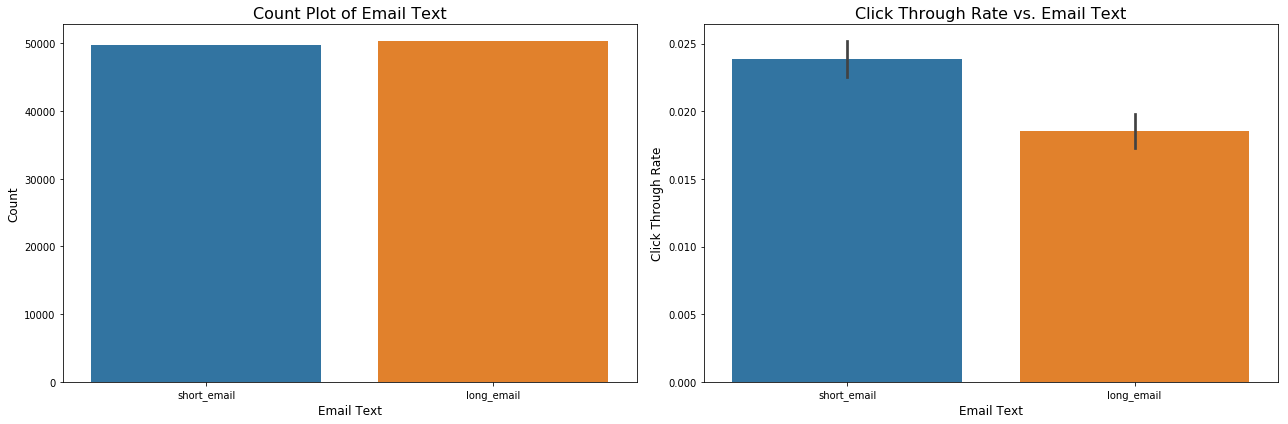

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x='email_text',data=data,ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize = 12)
ax[0].set_ylabel('Count', fontsize = 12)
ax[0].set_title('Count Plot of Email Text', fontsize = 16)

sns.barplot(x='email_text',y='clicked',data = data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

### CTR VS Email Version

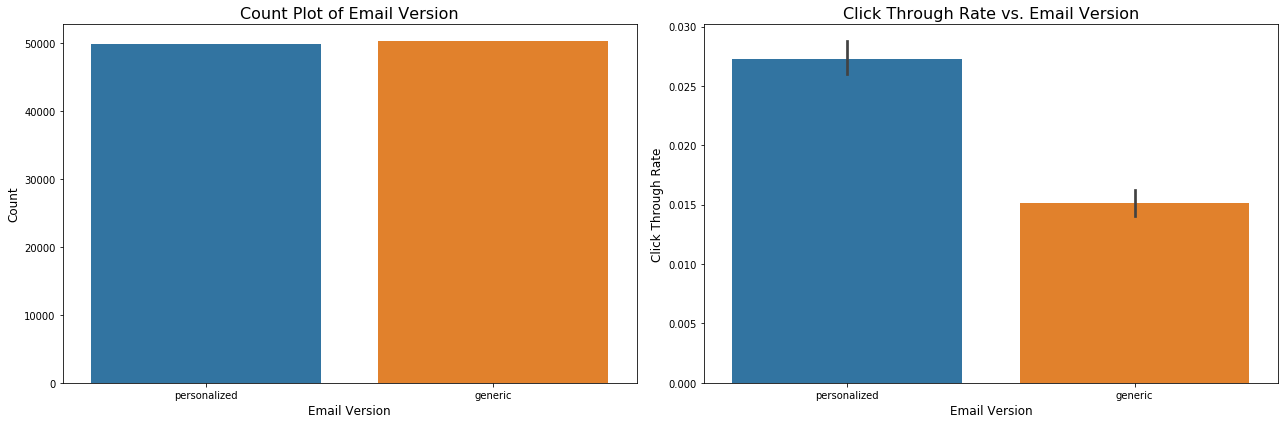

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

### CTR VS Hour

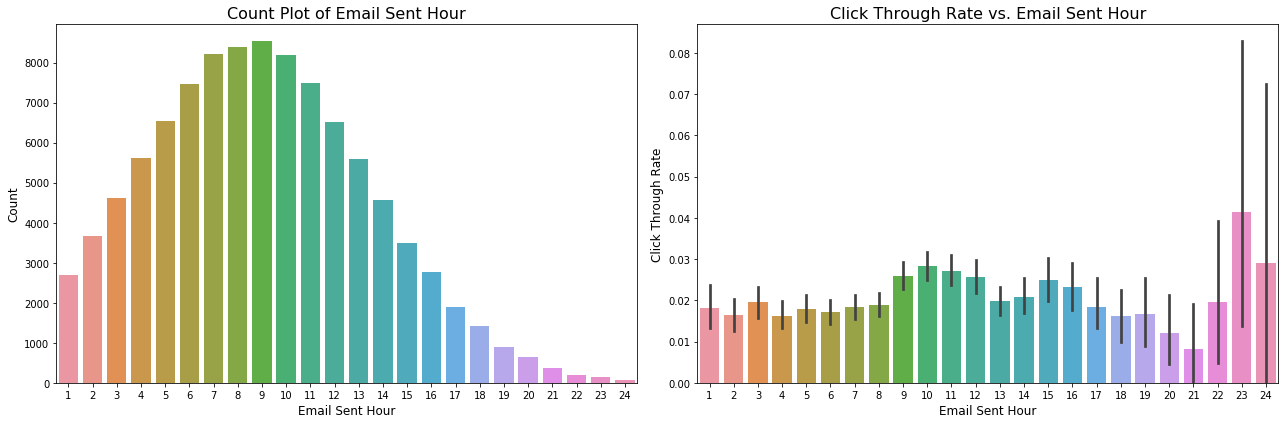

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

### CTR VS Day of Week

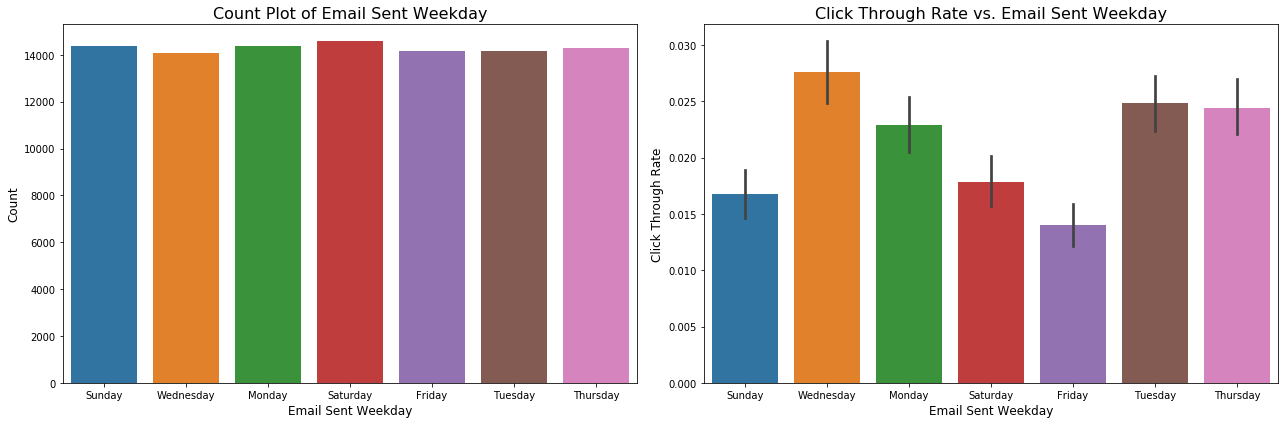

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

### CTR VS Country

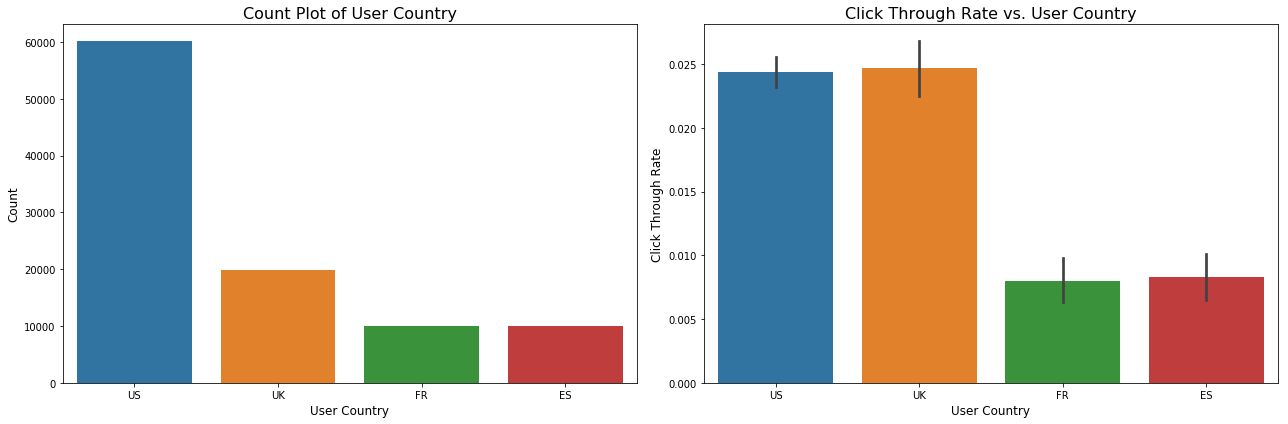

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

### CTR VS Past Purchases

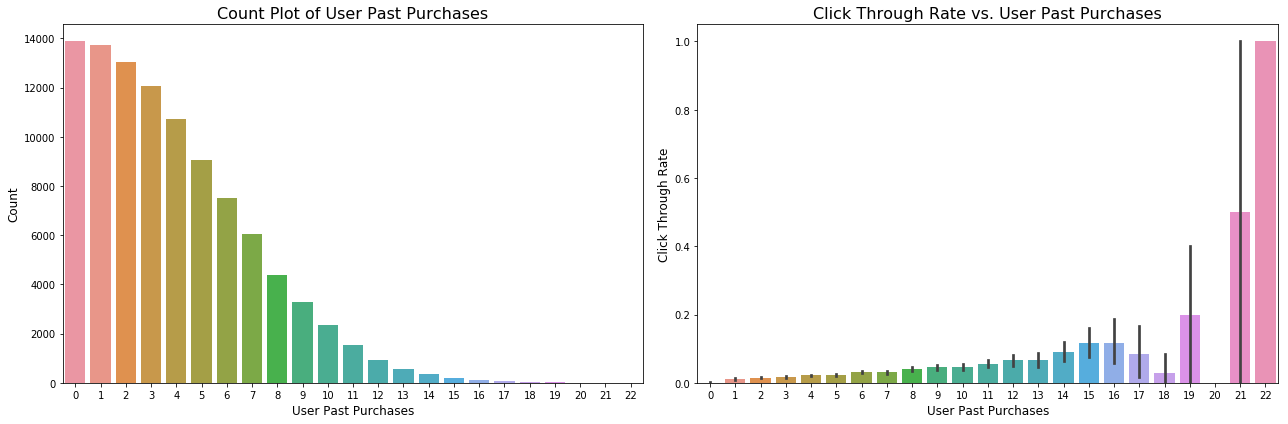

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

## Model Building

In [25]:
h2o.init()
h2o.remove_all()


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 days 3 hours 4 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,5 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_adamichael_hb4hi6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.563 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [26]:
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600017,,,9.059300000000105,,,3.8784500000000186,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.72753429407,,,4.439637441706958,,,3.1961097835771426,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [27]:
strat_split = h2o_df['clicked'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [28]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


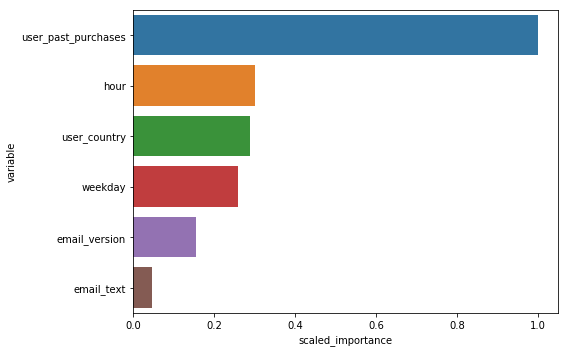

In [29]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [30]:
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [40]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)

In [42]:
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [60]:
roc_curve(train_true, train_pred)

(array([0.        , 0.        , 0.        , ..., 0.99985016, 0.99989102,
        1.        ]),
 array([0.00000000e+00, 6.29326621e-04, 1.88797986e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.23482285e+00, 2.34822848e-01, 1.38945734e-01, ...,
        4.97095234e-05, 2.55944576e-05, 2.40593500e-05]))

In [73]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.06).astype(int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     24470
           1       0.07      0.09      0.08       530

   micro avg       0.95      0.95      0.95     25000
   macro avg       0.52      0.53      0.53     25000
weighted avg       0.96      0.95      0.96     25000



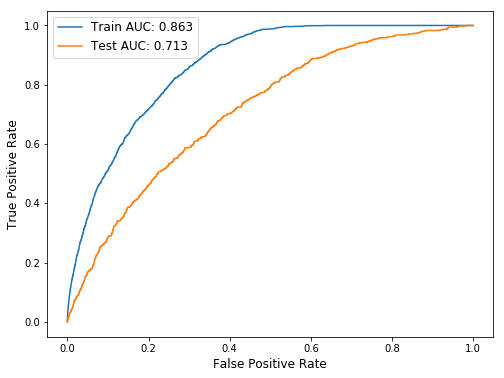

In [74]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


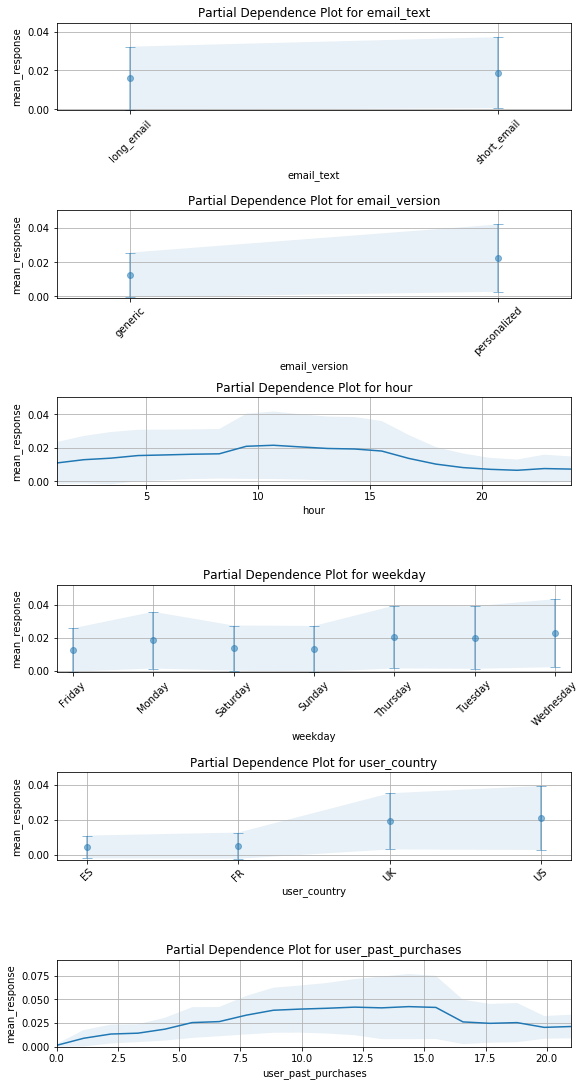

In [75]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))


In [76]:
h2o.cluster().shutdown()


H2O session _sid_8b07 closed.


# Question 3

By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

1. Randomly assign the total population into two parts.
2. For the first parts, continue the original strategy. Record the CTR.
3. For the second parts, apply the above model to make the prediction first, and only send emails to those have higher probability of click. Record the CTR.
4. Compare if the two CTR are statistically different at certain significance level.